# Read data, Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
words = stopwords.words('english')
import collections
accept_df = pd.read_excel("ICLR_accepted.xlsx")
reject_df = pd.read_excel("ICLR_rejected.xlsx")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeffp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing

In [2]:
test_df = pd.concat([accept_df[0].iloc[:50],reject_df[0].iloc[:50]])
train_accept = len(accept_df[0].iloc[50:])
train_reject = len(reject_df[0].iloc[50:])
train_df = pd.concat([accept_df[0].iloc[50:],reject_df[0].iloc[50:]])

In [3]:
# Lower words, remove stopwords 
instances = []
word_freqs = collections.Counter()

accept_sentences = []
accept_label = []
for obj in accept_df[0]:
    word_list = nltk.wordpunct_tokenize(obj.lower())
    word_list = [word for word in word_list if word not in stopwords.words('english')]
    accept_sentences.append([w.lower() for w in word_list if w.isalpha()])
    accept_label.append(1)
    for word in accept_sentences[-1]:
        word_freqs[word] += 1
        
reject_sentences = []
reject_label = []
for obj in reject_df[0]:
    word_list = nltk.wordpunct_tokenize(obj.lower())
    word_list = [word for word in word_list if word not in stopwords.words('english')]
    reject_sentences.append([w.lower() for w in word_list if w.isalpha()])
    reject_label.append(0)
    for word in reject_sentences[-1]:
        word_freqs[word] += 1

In [4]:
len(word_freqs)

2131

In [5]:
# build dictionary and padding
MAX_FEATURES = len(word_freqs)
MAX_SENTENCE_LENGTH = 10
#vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
vocab_size = MAX_FEATURES + 2 
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
for sent in range(0,len(accept_sentences)):
    seqs = []
    for word in accept_sentences[sent]:
        if(len(seqs)<MAX_SENTENCE_LENGTH):
            if(word in word2index):
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
        else:
            break
    if(len(seqs)<MAX_SENTENCE_LENGTH):
        for _ in range(MAX_SENTENCE_LENGTH - len(seqs)):
            seqs.append(word2index["PAD"])
    accept_sentences[sent] = seqs
    
for sent in range(0,len(reject_sentences)):
    seqs = []
    for word in reject_sentences[sent]:
        if(len(seqs)<MAX_SENTENCE_LENGTH):
            if(word in word2index):
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
    if(len(seqs)<MAX_SENTENCE_LENGTH):
        for _ in range(MAX_SENTENCE_LENGTH - len(seqs)):
            seqs.append(word2index["PAD"])
    reject_sentences[sent] = seqs

In [6]:
word2index['minimal']

628

In [7]:
# Split into training and testing
train_sent = accept_sentences[50:] + reject_sentences[50:]
train_label = accept_label[50:] + reject_label[50:]

test_sent = accept_sentences[:50] + reject_sentences[:50]
test_label = accept_label[:50] + reject_label[:50]

In [8]:
len(accept_sentences[50:]),len(reject_sentences[50:])

(532, 703)

In [9]:
import random
random_idx = list(range(0,len(train_sent)))
random.shuffle(random_idx)
new_train_sent = []
new_train_label = []
for single_id in random_idx:
    new_train_sent.append(train_sent[single_id])
    new_train_label.append(train_label[single_id])
train_sent = new_train_sent
train_label = new_train_label

In [10]:
np.array(train_sent)

array([[ 665,  147,   12, ...,    0,    0,    0],
       [ 154,  144,  116, ...,  914, 1843,    0],
       [   2, 1815, 1816, ...,    5,   12,  144],
       ...,
       [   4,  128, 1262, ...,    0,    0,    0],
       [1954,   23,  114, ...,    0,    0,    0],
       [  87,  846,    3, ...,    0,    0,    0]])

## Now, start building RNN/Lstm 

In [11]:
len(train_sent)

1235

In [12]:
sent_length = 10

In [13]:
mini_batch = 19
train_X = np.array(train_sent).reshape(-1, mini_batch,sent_length)
train_Y = np.array(train_label).reshape(-1, mini_batch)
test_X = np.array(test_sent).reshape(-1,1,sent_length)
test_Y = np.array(test_label).reshape(-1, 1)

In [14]:
len(train_X[0])

19

In [15]:
import torch
#train_X = torch.from_numpy(train_X)
train_X = torch.tensor(train_X, dtype=torch.float)
train_Y = torch.tensor(train_Y, dtype=torch.long)
test_X = torch.tensor(test_X, dtype=torch.long)
test_Y = torch.tensor(test_Y, dtype=torch.long)
org_train_X = train_X
# train_Y = torch.from_numpy(train_Y)
# test_X = torch.from_numpy(test_X)

In [16]:
train_Y

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 0, 1],
        ...,
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 0, 0, 1],
        [1, 0, 1,  ..., 1, 0, 0]])

In [17]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 5
TIME_STEP = sent_length         # rnn time step / image height
INPUT_SIZE = 1        # rnn input size / image width
LR = 0.01               # learning rate

embedding_dim = 128
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=embedding_dim,
            hidden_size=64,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out1 = nn.Linear(64, 16)
        self.out2 = nn.Linear(16, 2)
#         self.out3 = nn.Linear(6, 2)
#         self.out4 = nn.Linear(32, 2)

    def forward(self, x):
        embeds = self.word_embeddings(x)
#         print(embeds)
#         print(len(embeds),len(embeds[0]), len(embeds[0][0]),len(embeds[0][0][0]))
        embeds = embeds.view(-1,TIME_STEP,embedding_dim)
#         embeds = embeds.view(-1,embedding_dim,TIME_STEP)
#         print(len(embeds),len(embeds[0]), len(embeds[0][0]))
#         print(embeds)
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        
        r_out, (h_n, h_c) = self.rnn(embeds, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
#         out = F.softmax(self.out4(r_out[:, -1, :]))
        out = F.relu(self.out1(r_out[:, -1, :]))
        out = F.softmax(self.out2(out))
#         out = (self.out3(out))
        return out


rnn = RNN()
print(rnn)

# optimizer = torch.optim.SGD(rnn.parameters(), lr=0.0005, momentum=0.99)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
show_batch = float(50)

# training and testing

# training and testing
loss_record = []
train_record = []
test_record = []
for epoch in range(100):
    random_idx = list(range(0,len(train_sent)))
    random.shuffle(random_idx)
    new_train_sent = []
    new_train_label = []
    for single_id in random_idx:
        new_train_sent.append(train_sent[single_id])
        new_train_label.append(train_label[single_id])
    train_sent = new_train_sent
    train_label = new_train_label
    mini_batch = 5
    train_X = np.array(train_sent).reshape(-1, mini_batch,sent_length)
    train_Y = np.array(train_label).reshape(-1, mini_batch)
    train_X = torch.tensor(train_X, dtype=torch.long)
    train_Y = torch.tensor(train_Y, dtype=torch.long)
    random_idx = list(range(0,len(train_X)))
    random.shuffle(random_idx)
    count = 1
    h_state = None 
    batch_loss = 0
    for step in random_idx:
        b_x = train_X[step]
        b_y = train_Y[step]
        b_x = b_x.view(-1,sent_length,1)              # reshape x to (batch, time_step, input_size)
        
        
        output= rnn(b_x)                               # rnn output
#         print(output)
#         print(b_y)
        loss = loss_func(output, b_y)  # cross entropy loss
        batch_loss+=loss.data.numpy()
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
#         print(count)
        if count % 50 == 0:
            correct = 0
            total = 0
            h_state = None 
            for small_batch in range(len(train_X)):
                test_output = rnn(train_X[small_batch].view(-1,sent_length,1) )                   # (samples, time_step, input_size)
                pred_y = torch.max(test_output, 1)[1].data.numpy()
                
#                 accuracy = float((pred_y == train_label).astype(int).sum()) / float(train_label.size)
#                 print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
                
#                 print(small_batch)
                for pre in range(len(pred_y)):
#                     if(pred_y[pre]!=0):
#                         print('it is 1')
                    if(pred_y[pre]==train_label[small_batch*mini_batch+pre]):
                        correct+=1
                        
                    total+=1
            train_accuracy = correct/total
            
            correct = 0
            total = 0
            h_state = None 
            for small_batch in range(len(test_X)):
                test_output = rnn(test_X[small_batch].view(-1,sent_length,1) )                   # (samples, time_step, input_size)
                pred_y = torch.max(test_output, 1)[1].data.numpy()
                
#                 accuracy = float((pred_y == train_label).astype(int).sum()) / float(train_label.size)
#                 print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
                
#                 print(small_batch)
                for pre in range(len(pred_y)):
#                     if(pred_y[pre]!=0):
#                         print('it is 1')
                    if(pred_y[pre]==test_label[small_batch+pre]):
                        correct+=1
                        
                    total+=1
            test_accuracy = correct/total
            
            avg_loss = float(batch_loss)/show_batch
            batch_loss = 0
            print('Epoch: ', epoch, '| train loss: %.4f' % avg_loss, '| train accuracy: %.2f' % train_accuracy, '| test accuracy: %.2f' % test_accuracy)
        count+=1
    loss_record.append(avg_loss)
    train_record.append(train_accuracy)
    test_record.append(test_accuracy)

# # print 10 predictions from test data
# test_output = rnn(test_X[:10].view(-1,1,15))
# pred_y = torch.max(test_output, 1)[1].data.numpy()


# for epoch in range(EPOCH):
#     for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
#         b_x = b_x.view(-1, 1, 15)              # reshape x to (batch, time_step, input_size)
# #         print(len(b_x))

#         output = rnn(b_x)                               # rnn output
#         loss = loss_func(output, b_y)                   # cross entropy loss
#         optimizer.zero_grad()                           # clear gradients for this training step
#         loss.backward()                                 # backpropagation, compute gradients
#         optimizer.step()                                # apply gradients

#         if step % 50 == 0:
#             test_output = rnn(test_x)                   # (samples, time_step, input_size)
#             pred_y = torch.max(test_output, 1)[1].data.numpy()
#             accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

# print 10 predictions from test data
test_output = rnn(train_X[:2].view(-1,sent_length,1))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(train_label[:10], 'real number')

RNN(
  (word_embeddings): Embedding(2133, 128)
  (rnn): LSTM(128, 64, num_layers=2, batch_first=True)
  (out1): Linear(in_features=64, out_features=16, bias=True)
  (out2): Linear(in_features=16, out_features=2, bias=True)
)


C:\Users\jeffp\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  0 | train loss: 0.6903 | train accuracy: 0.57 | test accuracy: 0.50
Epoch:  0 | train loss: 0.6903 | train accuracy: 0.57 | test accuracy: 0.50
Epoch:  0 | train loss: 0.6876 | train accuracy: 0.57 | test accuracy: 0.50
Epoch:  0 | train loss: 0.6940 | train accuracy: 0.57 | test accuracy: 0.50
Epoch:  1 | train loss: 0.6874 | train accuracy: 0.57 | test accuracy: 0.50
Epoch:  1 | train loss: 0.6840 | train accuracy: 0.67 | test accuracy: 0.56
Epoch:  1 | train loss: 0.6626 | train accuracy: 0.61 | test accuracy: 0.54
Epoch:  1 | train loss: 0.6722 | train accuracy: 0.58 | test accuracy: 0.51
Epoch:  2 | train loss: 0.6025 | train accuracy: 0.70 | test accuracy: 0.47
Epoch:  2 | train loss: 0.5770 | train accuracy: 0.76 | test accuracy: 0.50
Epoch:  2 | train loss: 0.6137 | train accuracy: 0.74 | test accuracy: 0.42
Epoch:  2 | train loss: 0.6310 | train accuracy: 0.76 | test accuracy: 0.46
Epoch:  3 | train loss: 0.5063 | train accuracy: 0.82 | test accuracy: 0.47
Epoch:  3 | 

Epoch:  26 | train loss: 0.3801 | train accuracy: 0.94 | test accuracy: 0.48
Epoch:  26 | train loss: 0.3464 | train accuracy: 0.94 | test accuracy: 0.45
Epoch:  27 | train loss: 0.3456 | train accuracy: 0.94 | test accuracy: 0.43
Epoch:  27 | train loss: 0.3971 | train accuracy: 0.95 | test accuracy: 0.43
Epoch:  27 | train loss: 0.3700 | train accuracy: 0.94 | test accuracy: 0.43
Epoch:  27 | train loss: 0.3813 | train accuracy: 0.94 | test accuracy: 0.43
Epoch:  28 | train loss: 0.3532 | train accuracy: 0.95 | test accuracy: 0.47
Epoch:  28 | train loss: 0.3693 | train accuracy: 0.95 | test accuracy: 0.47
Epoch:  28 | train loss: 0.3688 | train accuracy: 0.95 | test accuracy: 0.47
Epoch:  28 | train loss: 0.3781 | train accuracy: 0.95 | test accuracy: 0.46
Epoch:  29 | train loss: 0.3748 | train accuracy: 0.95 | test accuracy: 0.45
Epoch:  29 | train loss: 0.3853 | train accuracy: 0.95 | test accuracy: 0.46
Epoch:  29 | train loss: 0.3493 | train accuracy: 0.95 | test accuracy: 0.46

Epoch:  53 | train loss: 0.3492 | train accuracy: 0.95 | test accuracy: 0.49
Epoch:  53 | train loss: 0.3693 | train accuracy: 0.95 | test accuracy: 0.49
Epoch:  53 | train loss: 0.3772 | train accuracy: 0.95 | test accuracy: 0.50
Epoch:  53 | train loss: 0.3612 | train accuracy: 0.95 | test accuracy: 0.49
Epoch:  54 | train loss: 0.3693 | train accuracy: 0.95 | test accuracy: 0.50
Epoch:  54 | train loss: 0.3759 | train accuracy: 0.95 | test accuracy: 0.49
Epoch:  54 | train loss: 0.3546 | train accuracy: 0.95 | test accuracy: 0.49
Epoch:  54 | train loss: 0.3663 | train accuracy: 0.95 | test accuracy: 0.49
Epoch:  55 | train loss: 0.3692 | train accuracy: 0.95 | test accuracy: 0.50
Epoch:  55 | train loss: 0.3693 | train accuracy: 0.95 | test accuracy: 0.50
Epoch:  55 | train loss: 0.3655 | train accuracy: 0.95 | test accuracy: 0.51
Epoch:  55 | train loss: 0.3493 | train accuracy: 0.95 | test accuracy: 0.50
Epoch:  56 | train loss: 0.3712 | train accuracy: 0.95 | test accuracy: 0.53

Epoch:  79 | train loss: 0.3413 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  79 | train loss: 0.3333 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  80 | train loss: 0.3533 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  80 | train loss: 0.3253 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  80 | train loss: 0.3653 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  80 | train loss: 0.3493 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  81 | train loss: 0.3413 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  81 | train loss: 0.3453 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  81 | train loss: 0.3413 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  81 | train loss: 0.3493 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  82 | train loss: 0.3493 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  82 | train loss: 0.3573 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  82 | train loss: 0.3453 | train accuracy: 0.97 | test accuracy: 0.53

In [18]:
len(train_sent)

1235

In [19]:
show_batch

50.0

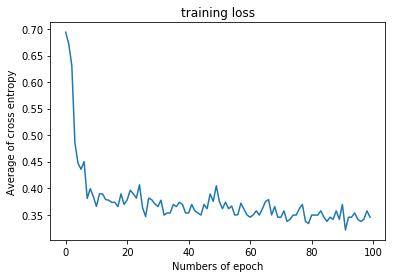

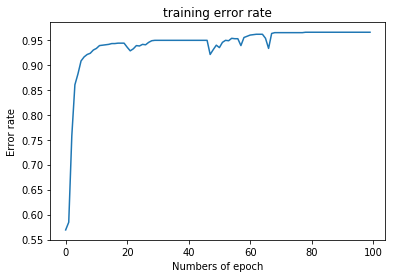

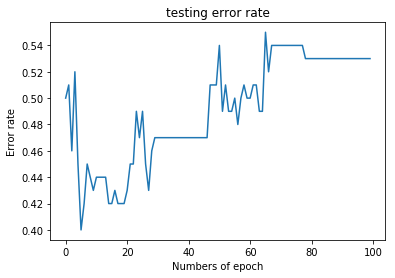

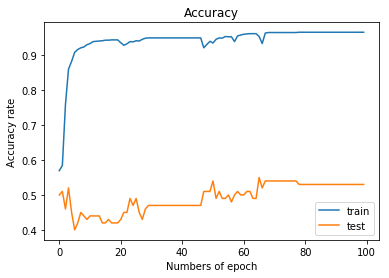

In [20]:
y = loss_record
x = list(range(0,len(y)))
plt.plot(x,y)
#plt.plot(list(range(0,len(self.entropy_record))), self.entropy_record)
plt.xlabel('Numbers of epoch')
#plt.xlabel('Numbers of iteration')
plt.ylabel('Average of cross entropy')
plt.title('training loss')
plt.show()

y = train_record
x = list(range(0,len(y)))
#training_error_rate = [1-acc for acc in self.training_error_record]
#plt.plot(list(range(0,len(training_error_rate))), training_error_rate)
plt.plot(x,y)
plt.xlabel('Numbers of epoch')
#plt.xlabel('Numbers of iteration')
plt.ylabel('Error rate')
plt.title('training error rate')
plt.show()


y = test_record
x = list(range(0,len(y)))
plt.plot(x,y)
#testing_error_rate = [1-acc for acc in self.testing_error_record]
#plt.plot(list(range(0,len(testing_error_rate))), testing_error_rate)
plt.xlabel('Numbers of epoch')
#plt.xlabel('Numbers of iteration')
plt.ylabel('Error rate')
plt.title('testing error rate')
plt.show()

# training, testing
x = list(range(0,len(train_record)))
plt.plot(x, train_record, label='train')
plt.plot(x, test_record, label='test')
plt.xlabel('Numbers of epoch')
plt.ylabel('Accuracy rate')
plt.title('Accuracy')
plt.legend()
plt.show()

RNN

In [24]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 5
TIME_STEP = sent_length         # rnn time step / image height
INPUT_SIZE = 1        # rnn input size / image width
LR = 0.01               # learning rate

embedding_dim = 128
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(         # if use nn.RNN(), it hardly learns
            input_size=embedding_dim,
            hidden_size=64,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out1 = nn.Linear(64, 16)
        self.out2 = nn.Linear(16, 2)
#         self.out3 = nn.Linear(6, 2)
#         self.out4 = nn.Linear(32, 2)

    def forward(self, x, hidden):
        embeds = self.word_embeddings(x)
#         print(embeds)
#         print(len(embeds),len(embeds[0]), len(embeds[0][0]),len(embeds[0][0][0]))
        embeds = embeds.view(-1,TIME_STEP,embedding_dim)
#         embeds = embeds.view(-1,embedding_dim,TIME_STEP)
#         print(len(embeds),len(embeds[0]), len(embeds[0][0]))
#         print(embeds)
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        
        r_out, (h_n, h_c) = self.rnn(embeds, hidden)   # None represents zero initial hidden state

        # choose r_out at the last time step
#         out = F.softmax(self.out4(r_out[:, -1, :]))
        out = F.relu(self.out1(r_out[:, -1, :]))
        out = F.softmax(self.out2(out))
#         out = (self.out3(out))
        return out, hidden


rnn = RNN()
print(rnn)

# optimizer = torch.optim.SGD(rnn.parameters(), lr=0.0005, momentum=0.99)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
show_batch = float(50)

# training and testing

# training and testing
loss_record = []
train_record = []
test_record = []
for epoch in range(100):
    random_idx = list(range(0,len(train_sent)))
    random.shuffle(random_idx)
    new_train_sent = []
    new_train_label = []
    for single_id in random_idx:
        new_train_sent.append(train_sent[single_id])
        new_train_label.append(train_label[single_id])
    train_sent = new_train_sent
    train_label = new_train_label
    mini_batch = 5
    train_X = np.array(train_sent).reshape(-1, mini_batch,sent_length)
    train_Y = np.array(train_label).reshape(-1, mini_batch)
    train_X = torch.tensor(train_X, dtype=torch.long)
    train_Y = torch.tensor(train_Y, dtype=torch.long)
    random_idx = list(range(0,len(train_X)))
    random.shuffle(random_idx)
    count = 1
    h_state = None 
    batch_loss = 0
    for step in random_idx:
        b_x = train_X[step]
        b_y = train_Y[step]
        b_x = b_x.view(-1,sent_length,1)              # reshape x to (batch, time_step, input_size)
        
        
        output, h_state= rnn(b_x, h_state)                               # rnn output
#         print(output)
#         print(b_y)
        loss = loss_func(output, b_y)  # cross entropy loss
        batch_loss+=loss.data.numpy()
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
#         print(count)
        if count % 50 == 0:
            correct = 0
            total = 0
            hh_state = None 
            for small_batch in range(len(train_X)):
                test_output,hh_state = rnn(train_X[small_batch].view(-1,sent_length,1),hh_state )                   # (samples, time_step, input_size)
                pred_y = torch.max(test_output, 1)[1].data.numpy()
                
#                 accuracy = float((pred_y == train_label).astype(int).sum()) / float(train_label.size)
#                 print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
                
#                 print(small_batch)
                for pre in range(len(pred_y)):
#                     if(pred_y[pre]!=0):
#                         print('it is 1')
                    if(pred_y[pre]==train_label[small_batch*mini_batch+pre]):
                        correct+=1
                        
                    total+=1
            train_accuracy = correct/total
            
            correct = 0
            total = 0
            hh_state = None 
            for small_batch in range(len(test_X)):
                test_output,hh_state = rnn(test_X[small_batch].view(-1,sent_length,1) ,hh_state)                   # (samples, time_step, input_size)
                pred_y = torch.max(test_output, 1)[1].data.numpy()
                
#                 accuracy = float((pred_y == train_label).astype(int).sum()) / float(train_label.size)
#                 print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
                
#                 print(small_batch)
                for pre in range(len(pred_y)):
#                     if(pred_y[pre]!=0):
#                         print('it is 1')
                    if(pred_y[pre]==test_label[small_batch+pre]):
                        correct+=1
                        
                    total+=1
            test_accuracy = correct/total
            
            avg_loss = float(batch_loss)/show_batch
            batch_loss = 0
            print('Epoch: ', epoch, '| train loss: %.4f' % avg_loss, '| train accuracy: %.2f' % train_accuracy, '| test accuracy: %.2f' % test_accuracy)
        count+=1
    loss_record.append(avg_loss)
    train_record.append(train_accuracy)
    test_record.append(test_accuracy)

# # print 10 predictions from test data
# test_output = rnn(test_X[:10].view(-1,1,15))
# pred_y = torch.max(test_output, 1)[1].data.numpy()


# for epoch in range(EPOCH):
#     for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
#         b_x = b_x.view(-1, 1, 15)              # reshape x to (batch, time_step, input_size)
# #         print(len(b_x))

#         output = rnn(b_x)                               # rnn output
#         loss = loss_func(output, b_y)                   # cross entropy loss
#         optimizer.zero_grad()                           # clear gradients for this training step
#         loss.backward()                                 # backpropagation, compute gradients
#         optimizer.step()                                # apply gradients

#         if step % 50 == 0:
#             test_output = rnn(test_x)                   # (samples, time_step, input_size)
#             pred_y = torch.max(test_output, 1)[1].data.numpy()
#             accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

# # print 10 predictions from test data
# h_state = None
# test_output = rnn(train_X[:2].view(-1,sent_length,1),h_state)
# pred_y = torch.max(test_output, 1)[1].data.numpy()
# print(pred_y, 'prediction number')
# print(train_label[:10], 'real number')

RNN(
  (word_embeddings): Embedding(2133, 128)
  (rnn): RNN(128, 64, num_layers=2, batch_first=True)
  (out1): Linear(in_features=64, out_features=16, bias=True)
  (out2): Linear(in_features=16, out_features=2, bias=True)
)


C:\Users\jeffp\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  0 | train loss: 0.6960 | train accuracy: 0.55 | test accuracy: 0.52
Epoch:  0 | train loss: 0.6918 | train accuracy: 0.55 | test accuracy: 0.53
Epoch:  0 | train loss: 0.6885 | train accuracy: 0.57 | test accuracy: 0.53
Epoch:  0 | train loss: 0.6892 | train accuracy: 0.57 | test accuracy: 0.51
Epoch:  1 | train loss: 0.6859 | train accuracy: 0.57 | test accuracy: 0.50
Epoch:  1 | train loss: 0.6906 | train accuracy: 0.59 | test accuracy: 0.50
Epoch:  1 | train loss: 0.6645 | train accuracy: 0.57 | test accuracy: 0.50
Epoch:  1 | train loss: 0.6903 | train accuracy: 0.59 | test accuracy: 0.51
Epoch:  2 | train loss: 0.6612 | train accuracy: 0.60 | test accuracy: 0.52
Epoch:  2 | train loss: 0.6631 | train accuracy: 0.61 | test accuracy: 0.51
Epoch:  2 | train loss: 0.6730 | train accuracy: 0.59 | test accuracy: 0.51
Epoch:  2 | train loss: 0.6755 | train accuracy: 0.64 | test accuracy: 0.50
Epoch:  3 | train loss: 0.6368 | train accuracy: 0.65 | test accuracy: 0.61
Epoch:  3 | 

Epoch:  26 | train loss: 0.3580 | train accuracy: 0.95 | test accuracy: 0.51
Epoch:  26 | train loss: 0.3722 | train accuracy: 0.95 | test accuracy: 0.48
Epoch:  27 | train loss: 0.3524 | train accuracy: 0.95 | test accuracy: 0.55
Epoch:  27 | train loss: 0.3662 | train accuracy: 0.95 | test accuracy: 0.53
Epoch:  27 | train loss: 0.3559 | train accuracy: 0.94 | test accuracy: 0.50
Epoch:  27 | train loss: 0.3877 | train accuracy: 0.95 | test accuracy: 0.51
Epoch:  28 | train loss: 0.3379 | train accuracy: 0.94 | test accuracy: 0.47
Epoch:  28 | train loss: 0.3815 | train accuracy: 0.94 | test accuracy: 0.50
Epoch:  28 | train loss: 0.3895 | train accuracy: 0.96 | test accuracy: 0.53
Epoch:  28 | train loss: 0.3530 | train accuracy: 0.95 | test accuracy: 0.46
Epoch:  29 | train loss: 0.3421 | train accuracy: 0.96 | test accuracy: 0.50
Epoch:  29 | train loss: 0.3661 | train accuracy: 0.96 | test accuracy: 0.49
Epoch:  29 | train loss: 0.3731 | train accuracy: 0.96 | test accuracy: 0.48

Epoch:  53 | train loss: 0.3525 | train accuracy: 0.97 | test accuracy: 0.52
Epoch:  53 | train loss: 0.3471 | train accuracy: 0.96 | test accuracy: 0.51
Epoch:  53 | train loss: 0.3460 | train accuracy: 0.97 | test accuracy: 0.52
Epoch:  53 | train loss: 0.3588 | train accuracy: 0.96 | test accuracy: 0.48
Epoch:  54 | train loss: 0.3787 | train accuracy: 0.94 | test accuracy: 0.52
Epoch:  54 | train loss: 0.3561 | train accuracy: 0.94 | test accuracy: 0.53
Epoch:  54 | train loss: 0.3874 | train accuracy: 0.97 | test accuracy: 0.48
Epoch:  54 | train loss: 0.3690 | train accuracy: 0.96 | test accuracy: 0.50
Epoch:  55 | train loss: 0.3377 | train accuracy: 0.96 | test accuracy: 0.49
Epoch:  55 | train loss: 0.3510 | train accuracy: 0.97 | test accuracy: 0.48
Epoch:  55 | train loss: 0.3707 | train accuracy: 0.97 | test accuracy: 0.50
Epoch:  55 | train loss: 0.3575 | train accuracy: 0.96 | test accuracy: 0.49
Epoch:  56 | train loss: 0.3651 | train accuracy: 0.94 | test accuracy: 0.46

Epoch:  79 | train loss: 0.3393 | train accuracy: 0.96 | test accuracy: 0.50
Epoch:  79 | train loss: 0.3433 | train accuracy: 0.97 | test accuracy: 0.50
Epoch:  80 | train loss: 0.3334 | train accuracy: 0.98 | test accuracy: 0.50
Epoch:  80 | train loss: 0.3383 | train accuracy: 0.98 | test accuracy: 0.50
Epoch:  80 | train loss: 0.3333 | train accuracy: 0.98 | test accuracy: 0.50
Epoch:  80 | train loss: 0.3399 | train accuracy: 0.98 | test accuracy: 0.50
Epoch:  81 | train loss: 0.3405 | train accuracy: 0.97 | test accuracy: 0.51
Epoch:  81 | train loss: 0.3494 | train accuracy: 0.97 | test accuracy: 0.53
Epoch:  81 | train loss: 0.3431 | train accuracy: 0.97 | test accuracy: 0.49
Epoch:  81 | train loss: 0.3367 | train accuracy: 0.95 | test accuracy: 0.46
Epoch:  82 | train loss: 0.3622 | train accuracy: 0.97 | test accuracy: 0.46
Epoch:  82 | train loss: 0.3338 | train accuracy: 0.98 | test accuracy: 0.50
Epoch:  82 | train loss: 0.3419 | train accuracy: 0.97 | test accuracy: 0.47

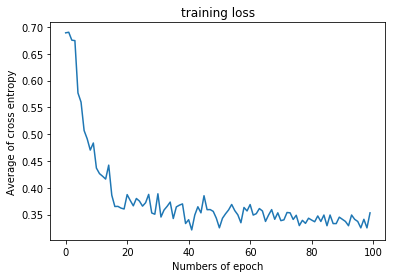

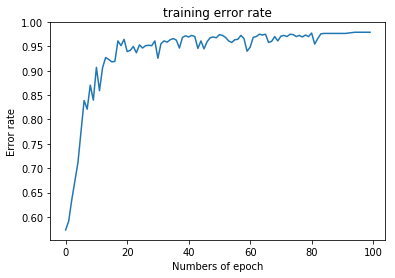

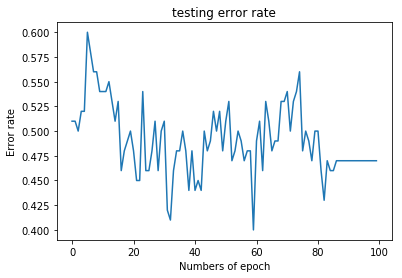

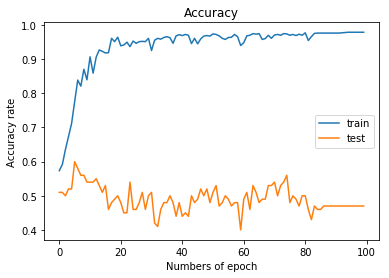

In [25]:
y = loss_record
x = list(range(0,len(y)))
plt.plot(x,y)
#plt.plot(list(range(0,len(self.entropy_record))), self.entropy_record)
plt.xlabel('Numbers of epoch')
#plt.xlabel('Numbers of iteration')
plt.ylabel('Average of cross entropy')
plt.title('training loss')
plt.show()

y = train_record
x = list(range(0,len(y)))
#training_error_rate = [1-acc for acc in self.training_error_record]
#plt.plot(list(range(0,len(training_error_rate))), training_error_rate)
plt.plot(x,y)
plt.xlabel('Numbers of epoch')
#plt.xlabel('Numbers of iteration')
plt.ylabel('Error rate')
plt.title('training error rate')
plt.show()


y = test_record
x = list(range(0,len(y)))
plt.plot(x,y)
#testing_error_rate = [1-acc for acc in self.testing_error_record]
#plt.plot(list(range(0,len(testing_error_rate))), testing_error_rate)
plt.xlabel('Numbers of epoch')
#plt.xlabel('Numbers of iteration')
plt.ylabel('Error rate')
plt.title('testing error rate')
plt.show()

# training, testing
x = list(range(0,len(train_record)))
plt.plot(x, train_record, label='train')
plt.plot(x, test_record, label='test')
plt.xlabel('Numbers of epoch')
plt.ylabel('Accuracy rate')
plt.title('Accuracy')
plt.legend()
plt.show()